In [574]:
import seaborn
import matplotlib.pyplot as plt
import pandas
import numpy
import matplotlib
import umap
from collections import defaultdict
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
seaborn.set_style("whitegrid")


# Data preprocessing
It this notebook stereo-seq data for mouse midbrain tissue are preprocessed to select important genes for accurate cells clusterization. 

## Data visualization and estimation
- Tissue visualization
- Cells initialization
- Gene expression distribution

#### Tissue visualization

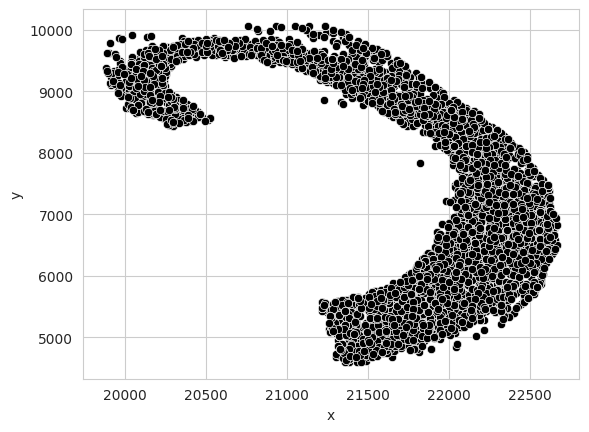

In [4]:
raw_data = pandas.read_csv("../data/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv", sep="\t")
seaborn.scatterplot(raw_data.sample(5000), x="x", y="y", color="black")
plt.show()

#### Cells initialization

In [5]:
class Gene(object):
    def __init__(self, name, expression):
        self.name = name
        self.expression = expression
    
    def updete(self, expression):
        self.expression += expression

class Cell(object):
    def __init__(self, cell_id, gene_name, x, y, expression):
        self.sell_id = cell_id
        self.x = x
        self.y = y
        self.genes = {gene_name: Gene(gene_name, expression)}
    
    def update(self, gene_name, expression):
        if gene_name in self.genes:
            self.genes[gene_name].update(expression)
        else:
            self.genes[gene_name] = Gene(gene_name, expression)


In [6]:
tissue_sample = dict()

In [7]:
for _, row in raw_data.iterrows():
    gene, x, y, expression, cell = (elem[1] for elem in row.items())
    if cell not in tissue_sample:
        tissue_sample[cell] = Cell(cell, gene, x, y, expression)
    else:
        tissue_sample[cell].update(gene, expression)


#### Gene expression distribution

In [8]:
genes_expression = defaultdict(int)

In [9]:
for k, cell in tissue_sample.items():
    for g_name, gene in cell.genes.items():
        genes_expression[g_name] += gene.expression

In [10]:
expression_data = pandas.DataFrame.from_dict(
    {
        "expression": [exp for exp in genes_expression.values() if exp < 500],
    }
)

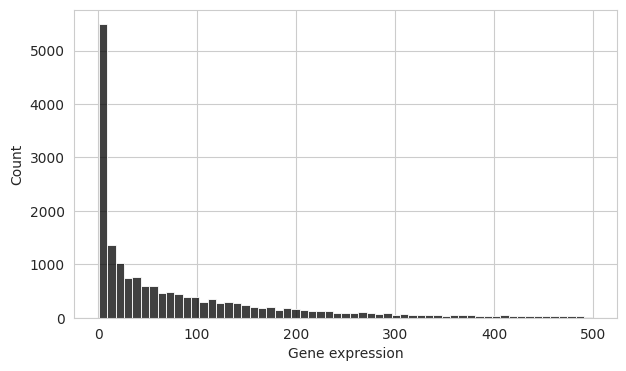

In [11]:
fig, ax = plt.subplots(figsize=(7, 4))
p1 = seaborn.histplot(data=expression_data, x="expression", color="black", ax=ax)
ax.set(xlabel="Gene expression", ylabel="Count")
plt.show()

## Gene expression normalization and filtration
- Log normalization of expression for each gene
- Heuristic filtration of genes according to expression destribution
- Between cell normalization

#### Log normalization
The most natural normalization for exponential destribution is logarithmic normalization

In [13]:
gene_names = []
original_gene_expression = []
for name, expression in genes_expression.items():
    gene_names.append(name)
    original_gene_expression.append(expression)
gene_names = numpy.array(gene_names)
original_gene_expression = numpy.array(original_gene_expression)
    
norm = max(original_gene_expression)
normalized_expression = numpy.log10(original_gene_expression / norm)
normalized_expression -= min(normalized_expression)
log_normalized_expression_data = pandas.DataFrame.from_dict(
    {
        "gene_name": gene_names,
        "expression": normalized_expression,
    }
)


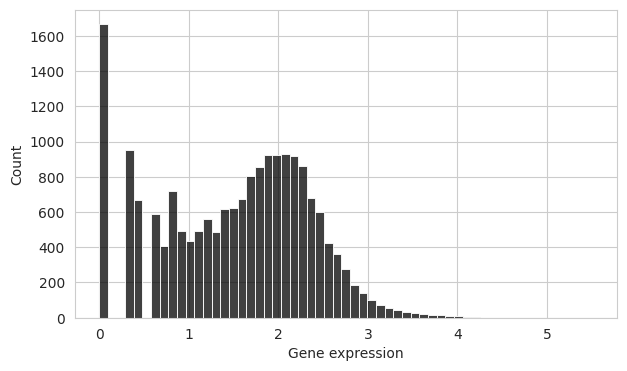

In [14]:
fig, ax = plt.subplots(figsize=(7, 4))
p1 = seaborn.histplot(
    data=log_normalized_expression_data, 
    x="expression", 
    color="black", 
    fill=True,
    ax=ax
)
ax.set(xlabel="Gene expression", ylabel="Count")
plt.show()

#### Heuristic genes filtering to reduce noizes in data

In [15]:
filtered_normalized_expression_data = log_normalized_expression_data[log_normalized_expression_data.expression > 1]
f_per = 100 * (1 - filtered_normalized_expression_data.size / log_normalized_expression_data.size)
print(
    f"Filtered {f_per:.2f}% of genes"
)

Filtered 30.61% of genes


#### How destributed well presented genes between cells?
If we have some gene which expression is equally destributed between cels, than this gene is not informative.  
To check it 25 most expressed genes are considered.

In [16]:
top_names = sorted([(v, g_name) for g_name, v in zip(gene_names, normalized_expression)], reverse=True)[:25]
top_names = [name for _, name in top_names]

In [17]:
between_cells_stat = defaultdict(list)
for g_name in top_names:
    for cell in tissue_sample.values():
        if g_name in cell.genes:
            between_cells_stat[g_name].append(cell.genes[g_name].expression)
        else:
            between_cells_stat[g_name].append(0)

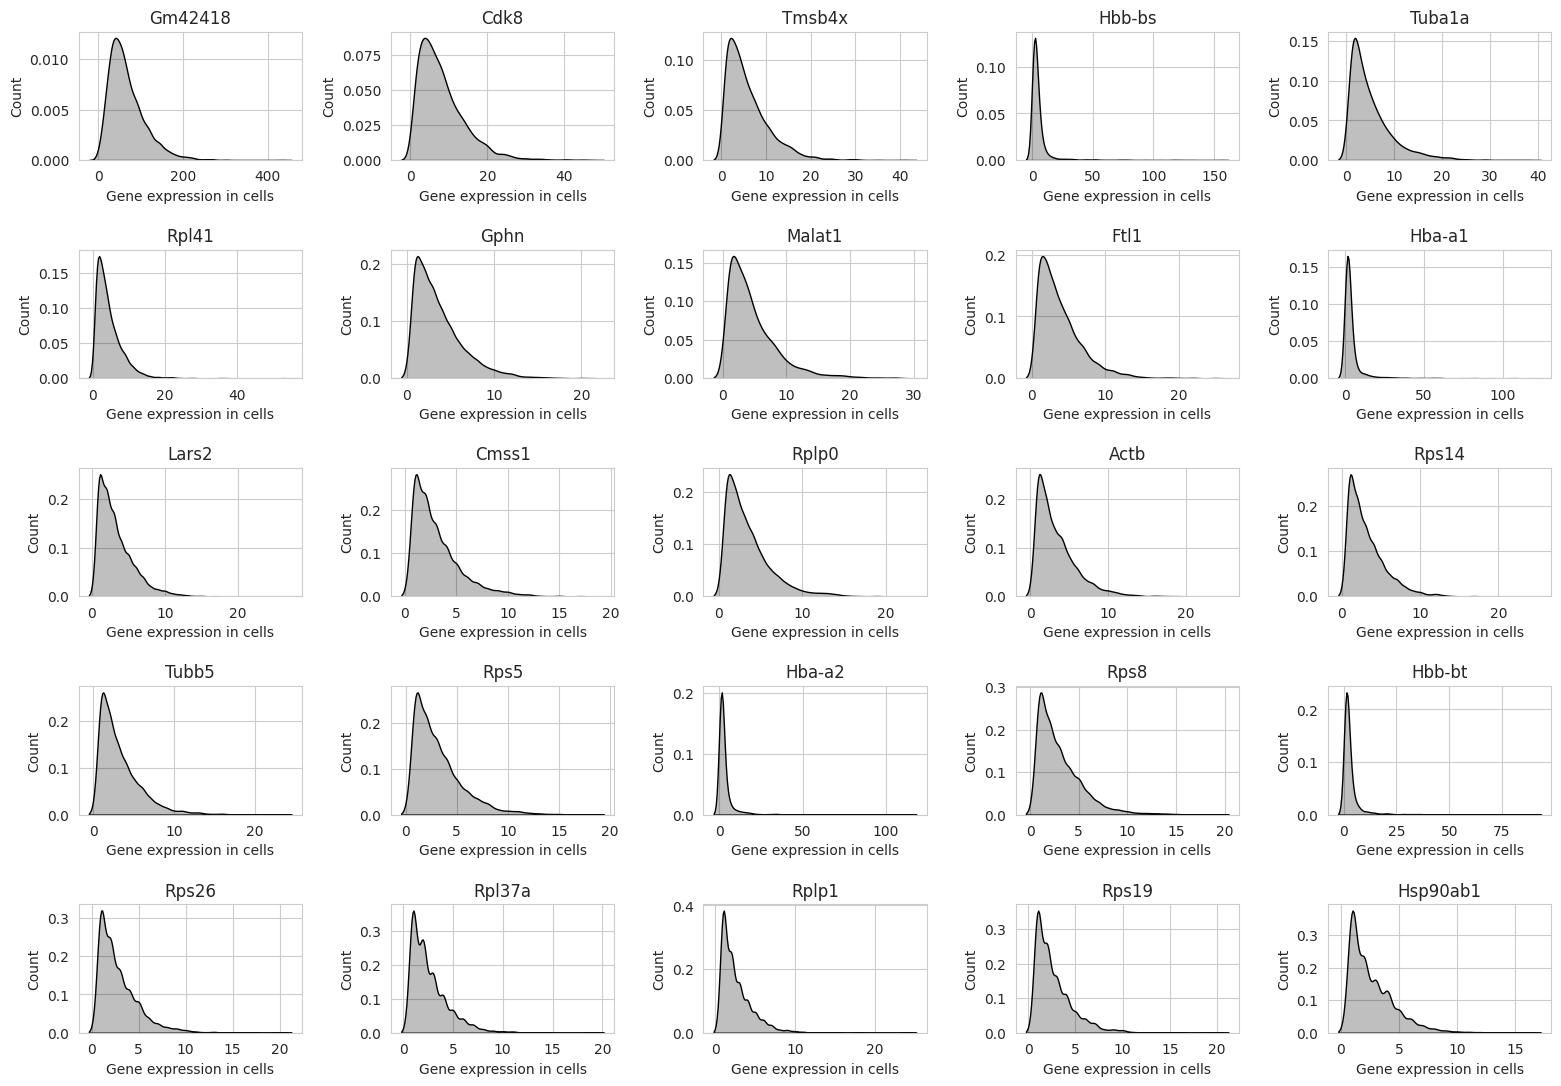

In [18]:
fig = plt.figure(figsize=(19, 13))
fig.subplots_adjust(hspace=.7, wspace=0.4)
for idx, (g_name, vals) in enumerate(between_cells_stat.items()):
    ax = fig.add_subplot(5, 5, idx + 1)
    p1 = seaborn.kdeplot(
        data=[v for v in vals if v != 0],
        color="black", 
        fill=True,
        ax=ax,
    )
    ax.set(xlabel="Gene expression in cells", ylabel="Count", title=g_name)
plt.show()


There is no uniformal destributed expressions, so, all this genes give us information to distinguish different cells

#### Between cell normalization
To normalize gene expression into one cell it devided on overall expression of this gene and multiplied on normolized value of this gene expression.

In [19]:
normalizad_filtered_gene_dict = dict()
for idx, row in filtered_normalized_expression_data.iterrows():
    name, expression = (elem[1] for elem in row.items())
    normalizad_filtered_gene_dict[name] = expression

In [20]:
normalized_tissue_sample = dict()
for cell_id, cell in tissue_sample.items():
    new_cell = deepcopy(cell)
    new_cell.genes = {
        name: Gene(name, gene.expression / genes_expression[name] * normalizad_filtered_gene_dict[name]) for name, gene in cell.genes.items() if name in normalizad_filtered_gene_dict
    }
    normalized_tissue_sample[cell_id] = new_cell

In [21]:
for gene in normalized_tissue_sample[170785].genes.values():
    print(gene.name, gene.expression)

Cnbp 0.0034394830924491786
Commd6 0.020320651682626773
Eif4g2 0.0014841187783838057
H2afy 0.002035604874146009
Lap3 0.03292515577574794
Mtap 0.05389732096194814
Rps26 0.0008792423578456578
Sept11 0.005746805992575175
Slc25a4 0.0032078766101860555
Tpr 0.014879159844329286


## Correlation analysis
- Corellation visualization
- Applying UMAP to reduce features dimentions

#### Corellation visualization
To visualization used top 25 expressed genes

In [22]:
gene_expression_in_cells = defaultdict(list)
cell_ids = list(normalized_tissue_sample.keys())
for g_name in filtered_normalized_expression_data.gene_name:
    for cell_id in cell_ids:
        if g_name in normalized_tissue_sample[cell_id].genes:
            gene_expression_in_cells[g_name].append(normalized_tissue_sample[cell_id].genes[g_name].expression)
        else:
            gene_expression_in_cells[g_name].append(0)


In [23]:
data = numpy.array([gene_expression_in_cells[name] for name in top_names]).T
d = pandas.DataFrame(data=data, columns=top_names)

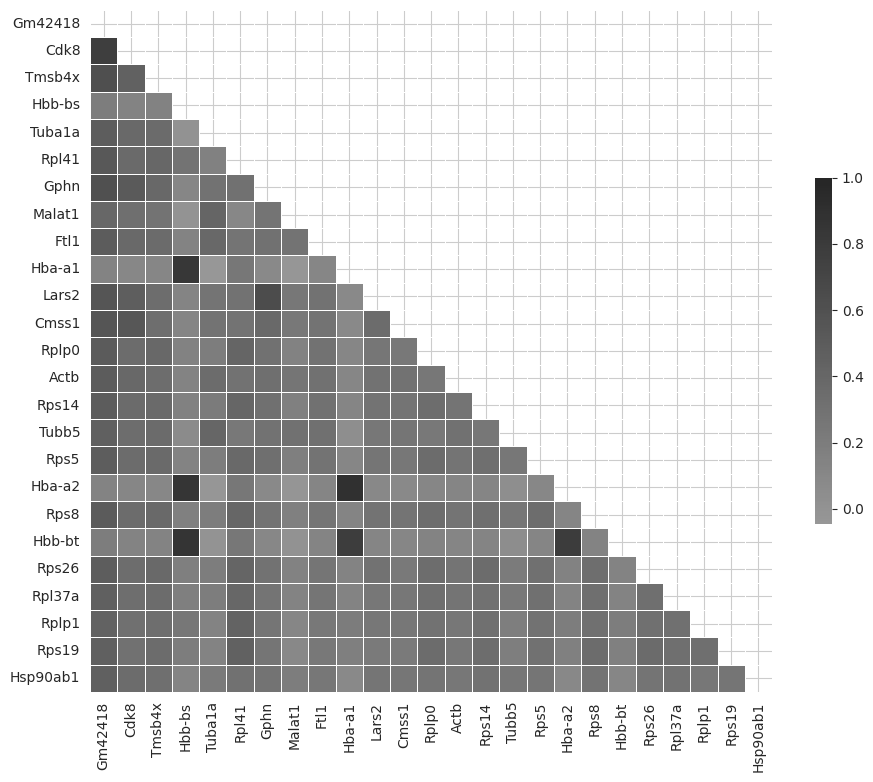

In [24]:
corr = d.corr()
mask = numpy.triu(numpy.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = seaborn.dark_palette("#FFFFFF", as_cmap=True, reverse=True)
seaborn.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5},
    vmin=corr.to_numpy().min(), 
    vmax=corr.to_numpy().max(),
)
plt.show()

#### Dimensionality reduction based on corellation
As it shown, some genes expression is corellated. Thus amount of features could be redused by using dimensionality reduction approaches such us UMAP.

Save whole filtered and normalized data before reduction

In [535]:
whole_gene_expression_dataset = pandas.DataFrame.from_dict(gene_expression_in_cells)
cells_ids_and_coordinates_dataset = pandas.DataFrame.from_dict(
    {
        "cell_id": cell_ids,
        "x": [normalized_tissue_sample[cell_id].x for cell_id in cell_ids],
        "y": [normalized_tissue_sample[cell_id].y for cell_id in cell_ids],
    }
)

In [36]:
normalized_result = pandas.concat([cells_ids_and_coordinates_dataset, whole_gene_expression_dataset], axis=1)

In [37]:
normalized_result

cell_id      x     y    Arpc1b  B230118H07Rik   Bcl2l12     Ccnd3   
0      170675  19881  9379  0.042837       0.032722  0.014507  0.007252  \
1      170785  19875  9350  0.000000       0.000000  0.000000  0.000000   
2      170808  19886  9330  0.000000       0.000000  0.029015  0.000000   
3      170818  19904  9160  0.000000       0.000000  0.000000  0.000000   
4      170819  19902  9216  0.000000       0.000000  0.000000  0.000000   
...       ...    ...   ...       ...            ...       ...       ...   
4867   181840  22663  6831  0.000000       0.000000  0.000000  0.000000   
4868   181841  22654  6877  0.057116       0.000000  0.000000  0.000000   
4869   181842  22666  6906  0.014279       0.000000  0.000000  0.000000   
4870   181843  22668  6560  0.000000       0.000000  0.000000  0.000000   
4871   181844  22695  6346  0.000000       0.000000  0.000000  0.000000   

          Cdk8    Commd4     Cops9  ...  Tmem28  Adcy10  Rbm11  Chac1   
0     0.000363  0.006774  0.007308  ...     0.0     0.0    0.0    0.0  \
1     0.000000  0.000000  0.000000  ...     0.0     0.0    0.0    0.0   
2     0.001209  0.000000  0.000000  ...     0.0     0.0    0.0    0.0   
3     0.000121  0.000000  0.000000  ...     0.0     0.0    0.0    0.0   
4     0.000000  0.000000  0.000000  ...     0.0     0.0    0.0    0.0   
...        ...       ...       ...  ...     ...     ...    ...    ...   
4867  0.001089  0.000000  0.000000  ...     0.0     0.0    0.0    0.0   
4868  0.001935  0.000000  0.003654  ...     0.0     0.0    0.0    0.0   
4869  0.000484  0.000000  0.003654  ...     0.0     0.0    0.0    0.0   
4870  0.000726  0.000000  0.000000  ...     0.0     0.0    0.0    0.0   
4871  0.000000  0.000000  0.000000  ...     0.0     0.0    0.0    0.0   

      Pcdhgb7  AC153140.2  A730060N03Rik  Stra6l  Gck  Ndst4  
0         0.0         0.0            0.0     0.0  0.0    0.0  
1         0.0         0.0            0.0     0.0  0.0    0.0  
2         0.0         0.0            0.0     0.0  0.0    0.0  
3         0.0         0.0            0.0     0.0  0.0    0.0  
4         0.0         0.0            0.0     0.0  0.0    0.0  
...       ...         ...            ...     ...  ...    ...  
4867      0.0         0.0            0.0     0.0  0.0    0.0  
4868      0.0         0.0            0.0     0.0  0.0    0.0  
4869      0.0         0.0            0.0     0.0  0.0    0.0  
4870      0.0         0.0            0.0     0.0  0.0    0.0  
4871      0.0         0.0            0.0     0.0  0.0    0.0  

[4872 rows x 12978 columns]

In [415]:
normalized_result.to_csv("../data/filtered_normalized_expression_in_cells.csv")

UMAP with correlation as metric used to reduce dimentions of expression dataset

In [561]:
reducer = umap.UMAP(metric="correlation", n_neighbors=10, n_components=20, n_epochs=500)

In [562]:
top_950_names = sorted([(v, g_name) for g_name, v in zip(gene_names, normalized_expression)], reverse=True)[:950]
top_950_names = [name for _, name in top_950_names]

In [563]:
to_reduce = whole_gene_expression_dataset[top_950_names].values

In [564]:
to_reduce.shape

(4872, 950)

In [565]:
embedding = reducer.fit_transform(to_reduce)
embedding.shape

(4872, 20)

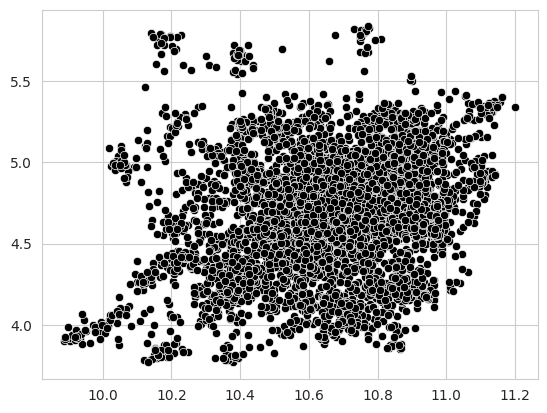

In [568]:
seaborn.scatterplot(x=embedding[:,0], y=embedding[:,1], color="black")
plt.show()

To check most important original features for UMAP correlation is measured

In [569]:
concat_df = pandas.concat([pandas.DataFrame(to_reduce), pandas.DataFrame(embedding)], axis=1)
corr_matrix = concat_df.corr()
original_reduced_corr = corr_matrix.iloc[:to_reduce.shape[1], to_reduce.shape[1]:]

To find most correlated (and "important" for UMAP) sum of values taked as a criteria. 

In [570]:
most_corellated_genes_idxs = sorted(
    [(sum(row), idx) for idx, row in original_reduced_corr.iterrows()], 
    reverse=True,
)

In [571]:
top_10_genes = [gene_names[idx] for _, idx in most_corellated_genes_idxs[:10]]
top_10_genes

['Rpl6',
 'Lamtor5',
 'Polr2e',
 'Ipo5',
 'Rab2a',
 'Hsp90aa1',
 'Parp8',
 'Rxrb',
 'Pafah1b3',
 'Ntm']

#### Some information about informative genes
- **Rpl6**: This gene encodes a protein component of the 60S ribosomal subunit. This protein can bind specifically to domain C of the tax-responsive enhancer element of human T-cell leukemia virus type 1, and may participate in tax-mediated transactivation of transcription. As is typical for genes encoding ribosomal proteins, there are multiple processed pseudogenes of this gene dispersed throughout the genome. Alternative splicing results in multiple transcript variants.
- **Lamtor5**: As part of the Ragulator complex it is involved in amino acid sensing and activation of mTORC1, a signaling complex promoting cell growth in response to growth factors, energy levels, and amino acids. Activated by amino acids through a mechanism involving the lysosomal V-ATPase, the Ragulator functions as a guanine nucleotide exchange factor activating the small GTPases Rag. Activated Ragulator and Rag GTPases function as a scaffold recruiting mTORC1 to lysosomes where it is in turn activated.
- **Polr2e**: This gene encodes the fifth largest subunit of RNA polymerase II, the polymerase responsible for synthesizing messenger RNA in eukaryotes. This subunit is shared by the other two DNA-directed RNA polymerases and is present in two-fold molar excess over the other polymerase subunits.
- **Ipo5**: Nucleocytoplasmic transport, a signal- and energy-dependent process, takes place through nuclear pore complexes embedded in the nuclear envelope. The import of proteins containing a nuclear localization signal (NLS) requires the NLS import receptor, a heterodimer of importin alpha and beta subunits also known as karyopherins. Importin alpha binds the NLS-containing cargo in the cytoplasm and importin beta docks the complex at the cytoplasmic side of the nuclear pore complex.

All of this genes are pretty different by their functionality, probably it's a reason why they are more informative for UMAP algorithm.

Save reduced dataset

In [572]:
reduced_gene_expression_dataset = pandas.DataFrame(embedding)
reduced_result = pandas.concat([cells_ids_and_coordinates_dataset, reduced_gene_expression_dataset], axis=1)
reduced_result.shape

(4872, 23)

In [573]:
reduced_result.to_csv("../data/reduced_dimentions_data.csv")